In [ ]:
!pip install geemap
!pip install earthengine-api
!pip install folium
!pip install geopandas
!pip install rasterio
!pip install shapely
!pip install earthpy
!pip install rasterstats
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 74.4 MB/s eta 0:00:00


In [ ]:
# @title Default title text
import ee
import geemap
import geopandas as gpd
import pandas as pd
import numpy as np
from rasterstats import zonal_stats
from shapely.geometry import shape
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [ ]:
# Authenticate your account. This will open an authentication window.
ee.Authenticate()

# Initialize the Earth Engine API
ee.Initialize(project='golden-tower-460705-s9')

In [ ]:
# Latitudes and longitudes
ranchi_center = ee.Geometry.Point([85.33, 23.34])

#buffer area
ranchi_area = ranchi_center.buffer(10000)


In [ ]:
# Load MODIS LST data for Ranchi over a specific date range
lst = ee.ImageCollection('MODIS/006/MOD11A1') \
    .filterBounds(ranchi_area) \
    .filterDate('2020-06-30', '2025-06-30') \
    .select('LST_Day_1km') \
    .mean()


# MODIS LST values are stored as Kelvin*100. Multiply by 0.02 to scale to Kelvin, then subtract 273.15 to convert to Celsius.
lst_celsius = lst.multiply(0.02).subtract(273.15)



/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MOD11A1! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1

  warnings.warn(warning, category=DeprecationWarning)


In [ ]:
# @title Default title text

#  [minLon, minLat, maxLon, maxLat]
# Example:Ranchi
city_bounds = ee.Geometry.Rectangle([85.25, 23.25, 85.42, 23.43]);



In [ ]:
# MODIS LST - Land Surface Temperature (convert K to °C)
lst = ee.ImageCollection('MODIS/006/MOD11A1') \
    .filterDate('2020-06-30', '2025-06-30') \
    .filterBounds(city_bounds) \
    .select('LST_Day_1km') \
    .mean().multiply(0.02).subtract(273.15)

# MODIS NDVI - Vegetation index
ndvi = ee.ImageCollection('MODIS/006/MOD13Q1') \
    .filterDate('2020-06-30', '2025-06-30') \
    .filterBounds(city_bounds) \
    .select('NDVI') \
    .mean().multiply(0.0001)

# Combine both into a single image
image = lst.rename('LST').addBands(ndvi.rename('NDVI'))

# Export GeoTIFF for local use
geemap.ee_export_image(image, filename='city_heat_ndvi.tif', scale=1000, region=city_bounds)

/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MOD13Q1! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1

  warnings.warn(warning, category=DeprecationWarning)


Generating URL ...
Please wait ...
Data downloaded to /content/city_heat_ndvi.tif


In [ ]:
# Export to Google Drive
task = ee.batch.Export.image.toDrive(
    image=lst,
    description='LST_Ranchi_May2023',
    scale=1000,  # 1km resolution
    region=city_bounds,
    fileFormat='GeoTIFF',  # or 'NPY'
    maxPixels=1e10
)
task.start()
print("Export started. Check Tasks tab in GEE Code Editor.")

Export started. Check Tasks tab in GEE Code Editor.


In [ ]:
!pip install osmnx geopandas --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 3.9 MB/s eta 0:00:00


<Axes: >

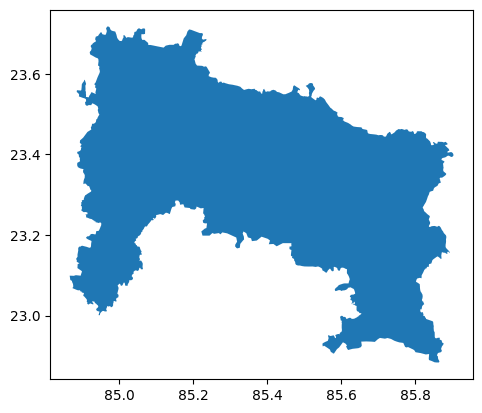

In [ ]:
import osmnx as ox
gdf = ox.geocode_to_gdf("Ranchi, Jharkhand, India")
gdf.plot()


In [ ]:
# Ranchi district approx central coordinates
latitude = 23.34
longitude = 85.33

roi = ee.Geometry.Point([longitude, latitude]).buffer(15000)

In [ ]:
def get_ndvi_image(roi):
    collection = ee.ImageCollection("COPERNICUS/S2_SR") \
        .filterBounds(roi) \
        .filterDate("2020-06-30", "2025-06-30") \
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10)) \
        .map(lambda img: img.addBands(img.normalizedDifference(["B8", "B4"]).rename("NDVI")))

    # Take median composite
    ndvi = collection.select("NDVI").median().clip(roi)
    return ndvi

ndvi_image = get_ndvi_image(roi)


/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


In [ ]:
Map = geemap.Map(center=[23.34, 85.33], zoom=10)
Map.addLayer(ndvi_image, {"min": 0, "max": 1, "palette": ["blue", "green"]}, "NDVI")
Map.addLayer(roi, {}, "ROI")
Map


Map(center=[23.34, 85.33], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [ ]:
import numpy as np
import geemap

url = ndvi_image.getDownloadURL({
    'scale': 30,
    'region': roi,
    'format': 'NPY'
})

print("Download NDVI NumPy from this link:")
print(url)

Download NDVI NumPy from this link:
https://earthengine.googleapis.com/v1/projects/golden-tower-460705-s9/thumbnails/40985d48fb7a8643af95a53c5cf76960-452308cd3919be46ae698de3a7da96e7:getPixels


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    206680
           1       1.00      1.00      1.00     10971

    accuracy                           1.00    217651
   macro avg       1.00      1.00      1.00    217651
weighted avg       1.00      1.00      1.00    217651



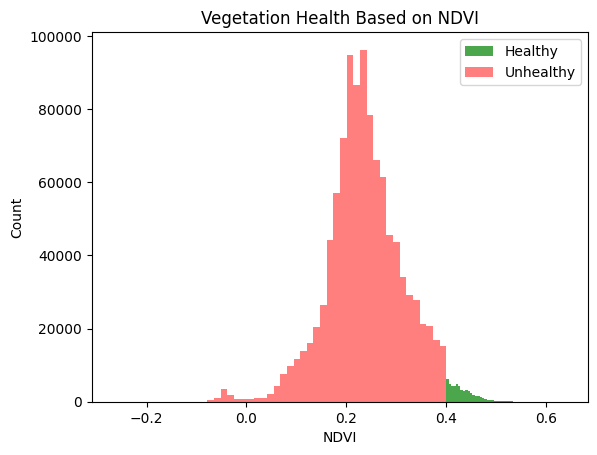

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load data
ndvi_data = np.load("/content/08680d8fba01e64490b619be9bf51318-8806b5722e60713476e7403072f3eb79_getPixels")
flat_ndvi = ndvi_data.flatten()

# Extract the float value from the tuples
flat_ndvi_cleaned = np.array([x[0] for x in flat_ndvi])


# Binarize NDVI for vegetation health (e.g., healthy > 0.4)
X = flat_ndvi_cleaned.reshape(-1, 1)
y = np.where(flat_ndvi_cleaned > 0.4, 1, 0)

# Remove NaNs
mask = ~np.isnan(X).flatten()
X_clean = X[mask]
y_clean = y[mask]

# Split and train
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and show results
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot sample result
plt.hist(X_clean[y_clean==1], bins=50, color='green', alpha=0.7, label="Healthy")
plt.hist(X_clean[y_clean==0], bins=50, color='red', alpha=0.5, label="Unhealthy")
plt.legend()
plt.title("Vegetation Health Based on NDVI")
plt.xlabel("NDVI")
plt.ylabel("Count")
plt.show()

In [ ]:
import os
import os

# Rename the uploaded file
os.rename("/content/08680d8fba01e64490b619be9bf51318-8806b5722e60713476e7403072f3eb79_getPixels", "ndvi_data.npy")

In [ ]:
import numpy as np

ndvi_data = np.load("ndvi_data.npy")
print("NDVI shape:", ndvi_data.shape)
print("NDVI sample values:", ndvi_data)


NDVI shape: (1003, 1085)
NDVI sample values: [[(0.34918845,) (0.43409428,) (0.44315672,) ... (0.19306266,)
  (0.21662241,) (0.186491  ,)]
 [(0.38141072,) (0.36114538,) (0.33317378,) ... (0.20528063,)
  (0.20835328,) (0.19352867,)]
 [(0.33427915,) (0.34861052,) (0.31426212,) ... (0.20540942,)
  (0.20689301,) (0.197239  ,)]
 ...
 [(0.3142967 ,) (0.27114183,) (0.3965554 ,) ... (0.28299677,)
  (0.323192  ,) (0.2662224 ,)]
 [(0.30056596,) (0.39040387,) (0.32880405,) ... (0.37594095,)
  (0.305117  ,) (0.2853986 ,)]
 [(0.3850177 ,) (0.33218884,) (0.36755472,) ... (0.37330458,)
  (0.31074053,) (0.35836816,)]]


In [ ]:
url = ndvi_image.getDownloadURL({
    'scale': 30,
    'region': roi,
    'format': 'NPY'
})

print("Download NDVI NumPy from this link:")
print(url)


Download NDVI NumPy from this link:
https://earthengine.googleapis.com/v1/projects/golden-tower-460705-s9/thumbnails/f683e694a1926e9fdaa19866ee71b78b-2ad435e6af8e54df17fb39ac1f6bcd61:getPixels


In [ ]:
!pip install nasa-power --quiet

In [ ]:
import requests
import pandas as pd
from io import StringIO


In [ ]:
# Define parameters
parameters = ["T2M", "RH2M", "PRECTOTCORR"]  # Temperature, Humidity, Precipitation
lat = 23.33
lon = 85.33
start = "20200630"
end = "20250630"

# API URL
url = f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters={','.join(parameters)}&community=AG&longitude={lon}&latitude={lat}&start={start}&end={end}&format=CSV"

# Request and read into DataFrame
response = requests.get(url)
if response.status_code == 200:
    # Read the entire CSV content
    csv_content = response.text
    # Find the line that indicates the end of the header
    header_end_line = None
    lines = csv_content.splitlines()
    for i, line in enumerate(lines):
        if "-END HEADER-" in line:
            header_end_line = i
            break

    if header_end_line is not None:
        # Read the CSV from the line after the header end, using the next line as the header
        data = pd.read_csv(StringIO("\n".join(lines[header_end_line + 1:])), header=0)

        # Rename columns to remove leading spaces if any
        data.columns = data.columns.str.strip()

        # Create a 'DATE' column from 'YEAR' and 'DOY'
        data['DATE'] = pd.to_datetime(data['YEAR'].astype(str) + data['DOY'].astype(str), format='%Y%j')

        print("Climate data loaded successfully!")
        display(data.head())
    else:
        print("Could not find the end of the header in the CSV.")
else:
    print("Failed to fetch data:", response.status_code)

data.tail()


Climate data loaded successfully!


,YEAR,DOY,T2M,RH2M,PRECTOTCORR,DATE
0,2020,182,27.41,80.75,1.12,2020-06-30
1,2020,183,27.85,78.31,0.56,2020-07-01
2,2020,184,28.01,83.34,2.18,2020-07-02
3,2020,185,27.61,85.92,0.92,2020-07-03
4,2020,186,27.62,83.89,1.44,2020-07-04


,YEAR,DOY,T2M,RH2M,PRECTOTCORR,DATE
1816,2025,171,25.72,89.26,21.53,2025-06-20
1817,2025,172,27.15,83.14,4.29,2025-06-21
1818,2025,173,-999.00,-999.00,-999.00,2025-06-22
1819,2025,174,-999.00,-999.00,-999.00,2025-06-23
1820,2025,175,-999.00,-999.00,-999.00,2025-06-24


In [ ]:
data.to_csv("ranchi_climate_data.csv", index=False)

In [ ]:
import pandas as pd

# Load your climate data
climate_df = pd.read_csv("ranchi_climate_data.csv")

climate_df.head()

climate_df.tail()


,YEAR,DOY,T2M,RH2M,PRECTOTCORR,DATE
1816,2025,171,25.72,89.26,21.53,2025-06-20
1817,2025,172,27.15,83.14,4.29,2025-06-21
1818,2025,173,-999.00,-999.00,-999.00,2025-06-22
1819,2025,174,-999.00,-999.00,-999.00,2025-06-23
1820,2025,175,-999.00,-999.00,-999.00,2025-06-24


In [ ]:
climate_df_avg = data[["T2M", "RH2M", "PRECTOTCORR"]].mean()
print("Average Climate Values:\n", climate_df_avg)

Average Climate Values:
 T2M            22.703454
RH2M           63.677639
PRECTOTCORR     2.447392
dtype: float64


In [ ]:
# Access the 'NDVI' field before calculating the mean
mean_ndvi = ndvi_data['NDVI'].mean()

print("Mean NDVI:", mean_ndvi)

Mean NDVI: 0.24484746


In [ ]:
def classify_risk(temp, humidity, rain, ndvi):
    if temp > 35 and humidity < 40 and ndvi < 0.3:
        return "High"
    elif 30 < temp <= 35 or ndvi < 0.45:
        return "Medium"
    else:
        return "Low"

# Create a DataFrame
data = pd.DataFrame({
    "Temperature": [climate_df_avg["T2M"]],
    "Humidity": [climate_df_avg["RH2M"]],
    "Rainfall": [climate_df_avg["PRECTOTCORR"]],
    "NDVI": [mean_ndvi]
})

data["RiskLevel"] = data.apply(lambda row: classify_risk(row["Temperature"], row["Humidity"], row["Rainfall"], row["NDVI"]), axis=1)
print(data)
print(data["RiskLevel"].unique())


   Temperature   Humidity  Rainfall      NDVI RiskLevel
0    22.703454  63.677639  2.447392  0.244847    Medium
['Medium']


In [ ]:
import numpy as np

# Create synthetic data
np.random.seed(42)
samples = 200

synthetic_data = pd.DataFrame({
    "Temperature": np.random.normal(32, 5, samples),
    "Humidity": np.random.normal(50, 15, samples),
    "Rainfall": np.random.normal(5, 3, samples),
    "NDVI": np.random.uniform(0.2, 0.8, samples),
})

# Generate labels
synthetic_data["RiskLevel"] = synthetic_data.apply(
    lambda row: classify_risk(row["Temperature"], row["Humidity"], row["Rainfall"], row["NDVI"]), axis=1
)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Encode labels
le = LabelEncoder()
synthetic_data["Label"] = le.fit_transform(synthetic_data["RiskLevel"])

X = synthetic_data[["Temperature", "Humidity", "Rainfall", "NDVI"]]
y = synthetic_data["Label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("predicted values are as follows", y_pred)


[[ 0  0  1]
 [ 0 12  0]
 [ 0  0 27]]
              precision    recall  f1-score   support

        High       0.00      0.00      0.00         1
         Low       1.00      1.00      1.00        12
      Medium       0.96      1.00      0.98        27

    accuracy                           0.97        40
   macro avg       0.65      0.67      0.66        40
weighted avg       0.95      0.97      0.96        40

predicted values are as follows [2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 2 2 1 2 2 1 1 1 1 2 2 2 2 1 1 2 2 2
 2 2 2]


In [ ]:
# Install required packages
!pip install nasapy
!pip install plotly

In [ ]:
!pip install requests pandas

import requests
import pandas as pd
from datetime import datetime, timedelta

# Ranchi District coordinates
latitude = 20.75
longitude = 84.25

# Date range (last 5 years)
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

# API parameters
params = {
    'start': start_date.strftime('%Y%m%d'),
    'end': end_date.strftime('%Y%m%d'),
    'latitude': latitude,
    'longitude': longitude,
    'community': 'AG',
    'parameters': 'T2M,T2M_MAX,T2M_MIN,RH2M',
    'format': 'JSON',
    'user': 'anonymous'
}

# Make the API request
url = "https://power.larc.nasa.gov/api/temporal/daily/point"
response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
    # Convert to DataFrame - directly use the 'parameter' data
    weather_data = pd.DataFrame(data['properties']['parameter'])
    # The index of this DataFrame is already the date in 'YYYYMMDD' format string
    # Convert the index to datetime objects
    weather_data.index = pd.to_datetime(weather_data.index, format='%Y%m%d')

    print("Data successfully retrieved:")
    print(weather_data.head())
    print(weather_data.tail())
else:
    print(f"Error fetching data: {response.status_code}")
    print(response.text)

Data successfully retrieved:
              T2M  T2M_MAX  T2M_MIN   RH2M
2020-06-25  29.06    32.84    25.28  81.43
2020-06-26  27.57    29.77    25.35  87.24
2020-06-27  27.15    30.23    24.77  88.21
2020-06-28  27.11    29.82    24.79  88.95
2020-06-29  27.32    30.08    24.61  85.90
               T2M  T2M_MAX  T2M_MIN    RH2M
2025-06-20   27.25    30.80    24.07   78.53
2025-06-21   29.49    34.44    25.04   65.56
2025-06-22 -999.00  -999.00  -999.00 -999.00
2025-06-23 -999.00  -999.00  -999.00 -999.00
2025-06-24 -999.00  -999.00  -999.00 -999.00


In [ ]:
# Convert date column to datetime and set as index
# weather_data['date'] = pd.to_datetime(weather_data['date']) # This line is no longer needed
# weather_data.set_index('date', inplace=True) # This line is no longer needed

# Calculate additional features using the index
weather_data['month'] = weather_data.index.month
weather_data['year'] = weather_data.index.year
weather_data['day_of_year'] = weather_data.index.dayofyear

# Calculate Heat Index (using simplified formula)
weather_data['heat_index'] = weather_data['T2M'] + 0.5 * (weather_data['RH2M']/100) * (weather_data['T2M'] - 20)

# Create target variable (risk categories)
def classify_risk(row):
    if row['T2M_MAX'] > 45:
        return 3  # Extreme
    elif row['T2M_MAX'] > 40:
        return 2  # High
    elif row['T2M_MAX'] > 35:
        return 1  # Moderate
    else:
        return 0  # Low

weather_data['risk_category'] = weather_data.apply(classify_risk, axis=1)

# Handle missing values (specifically the -999.0 fill value from NASA POWER)
weather_data.replace(-999.0, np.nan, inplace=True)
weather_data.fillna(method='ffill', inplace=True)

print(weather_data[['T2M_MAX', 'RH2M', 'heat_index', 'risk_category']].head())

            T2M_MAX   RH2M  heat_index  risk_category
2020-06-25    32.84  81.43   32.748779              0
2020-06-26    29.77  87.24   30.872034              0
2020-06-27    30.23  88.21   30.303507              0
2020-06-28    29.82  88.95   30.272172              0
2020-06-29    30.08  85.90   30.463940              0


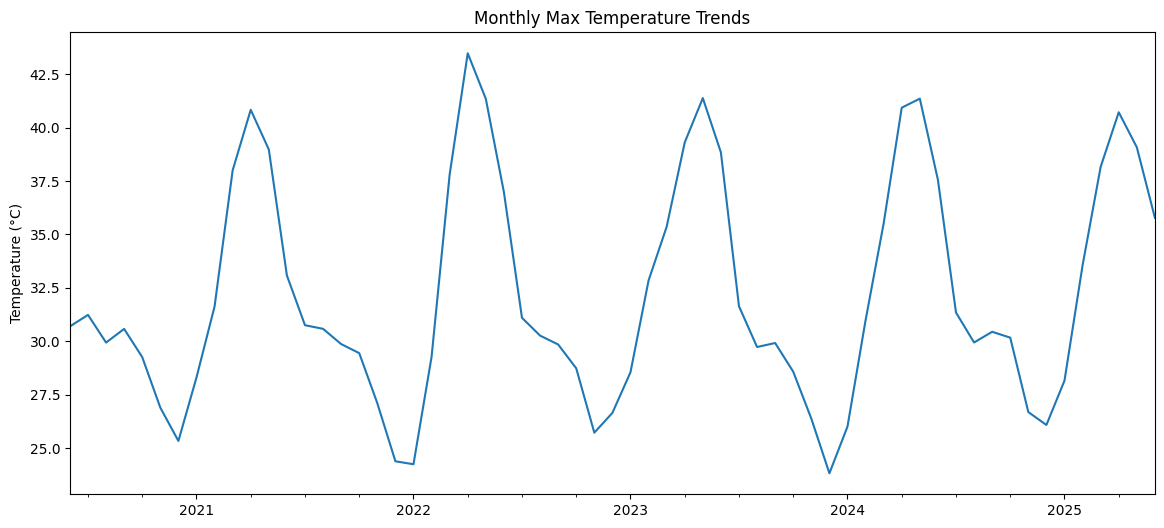

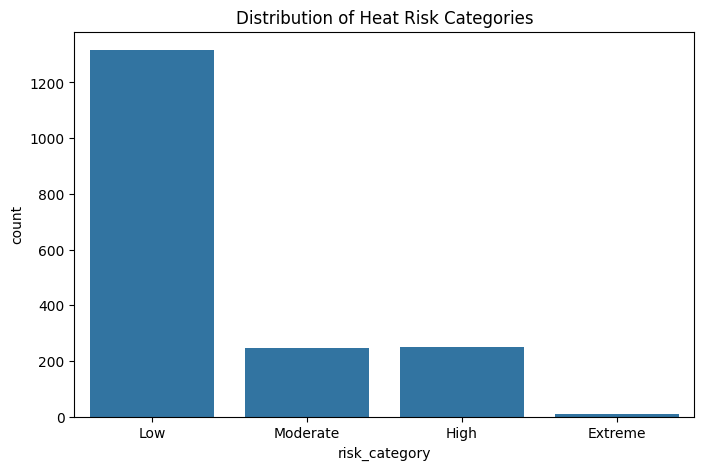

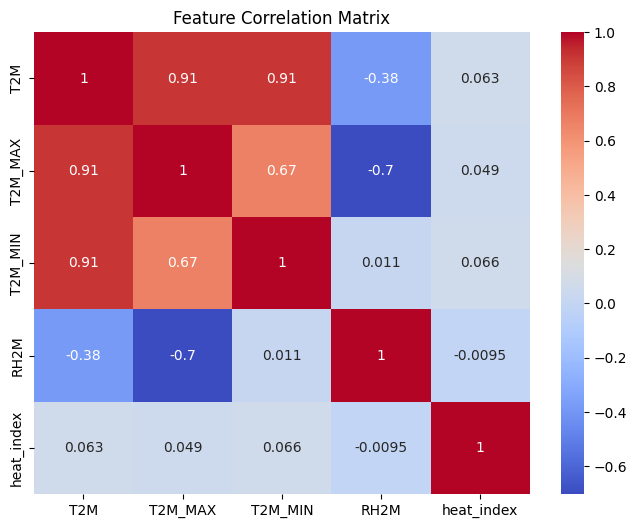

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Temperature Trends
plt.figure(figsize=(14,6))
weather_data['T2M_MAX'].resample('M').mean().plot(title='Monthly Max Temperature Trends')
plt.ylabel('Temperature (°C)')
plt.show()

# 2. Risk Category Distribution
plt.figure(figsize=(8,5))
sns.countplot(x='risk_category', data=weather_data.reset_index())
plt.title('Distribution of Heat Risk Categories')
plt.xticks([0,1,2,3], ['Low','Moderate','High','Extreme'])
plt.show()

# 3. Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(weather_data[['T2M','T2M_MAX','T2M_MIN','RH2M','heat_index']].corr(),
            annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

Classification Report:
               precision    recall  f1-score   support

         Low       1.00      1.00      1.00       264
    Moderate       0.96      0.98      0.97        51
        High       1.00      0.96      0.98        49
     Extreme       1.00      1.00      1.00         2

    accuracy                           0.99       366
   macro avg       0.99      0.98      0.99       366
weighted avg       0.99      0.99      0.99       366

Accuracy: 0.9918032786885246


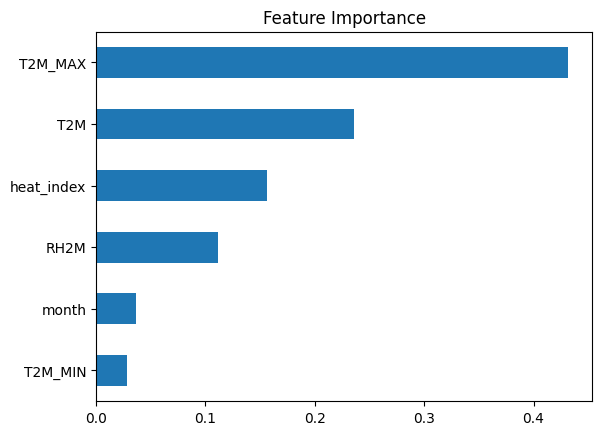

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Prepare features and target
X = weather_data[['month', 'T2M', 'T2M_MAX', 'T2M_MIN', 'RH2M', 'heat_index']]
y = weather_data['risk_category']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred,
      target_names=['Low','Moderate','High','Extreme']))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Feature Importance
pd.Series(model.feature_importances_, index=X.columns).sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.show()

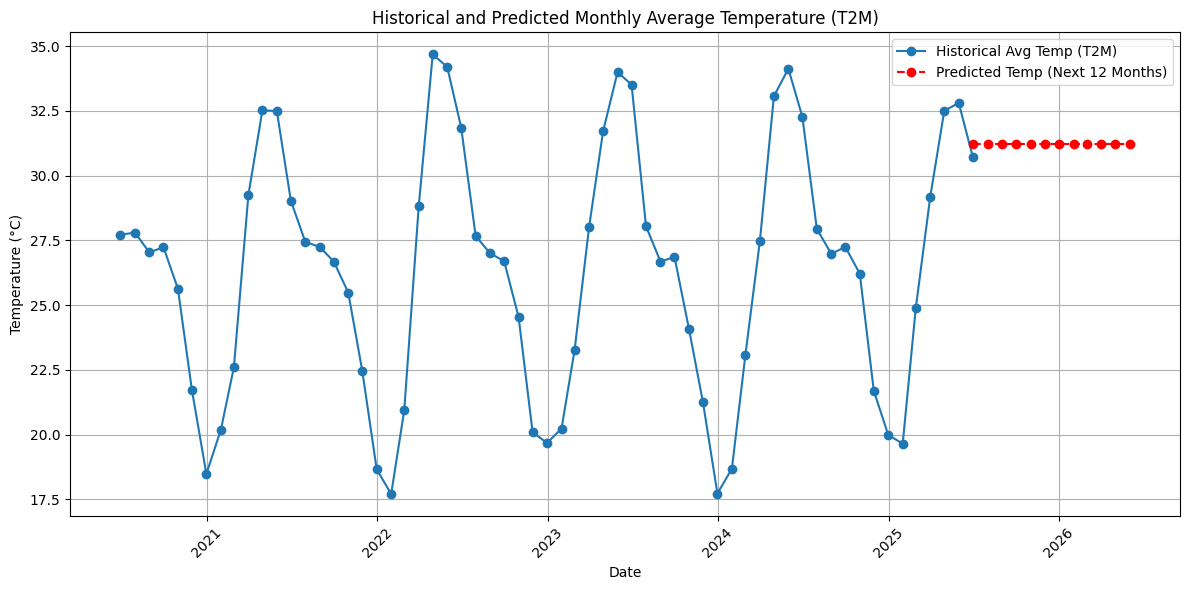

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

# Assuming you already have 'weather_data' with daily values from NASA
# Step 1: Convert daily to monthly mean
monthly_data = weather_data.resample('M').mean().reset_index()
monthly_data['month_number'] = np.arange(len(monthly_data))  # Time feature

# Step 2: Train model
X = monthly_data[['month_number']]
y = monthly_data['T2M']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Step 3: Predict next 12 months
last_month = monthly_data['month_number'].iloc[-1]
future_months = np.arange(last_month + 1, last_month + 13).reshape(-1, 1)
future_predictions = model.predict(future_months)

# Step 4: Create future dates
last_date = monthly_data['index'].iloc[-1]  # last date in monthly data
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')

# Step 5: Plotting
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['index'], monthly_data['T2M'], label='Historical Avg Temp (T2M)', marker='o')
plt.plot(future_dates, future_predictions, label='Predicted Temp (Next 12 Months)', linestyle='--', marker='o', color='red')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Historical and Predicted Monthly Average Temperature (T2M)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


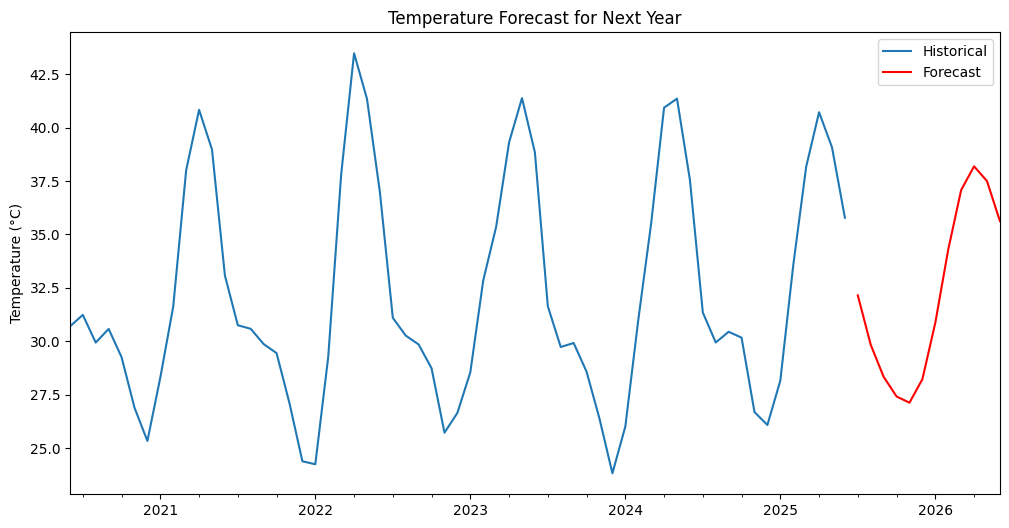

Predicted Risk Categories for Next 12 Months: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Prepare time series data
temp_series = weather_data['T2M_MAX'].resample('M').mean()

# Train ARIMA model
model_arima = ARIMA(temp_series, order=(5,1,2))
model_fit = model_arima.fit()

# Forecast next 12 months
forecast = model_fit.forecast(steps=12)

# Visualize
plt.figure(figsize=(12,6))
temp_series.plot(label='Historical')
forecast.plot(label='Forecast', color='red')
plt.title('Temperature Forecast for Next Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Convert forecast to risk categories
forecast_risk = [classify_risk({'T2M_MAX': temp}) for temp in forecast]
print("Predicted Risk Categories for Next 12 Months:", forecast_risk)

In [ ]:
# Define impact assessment functions
def vegetation_impact(risk):
    impacts = {
        0: "Normal growth",
        1: "Mild stress",
        2: "Reduced yields",
        3: "Crop failure likely"
    }
    return impacts[risk]

def health_impact(risk):
    impacts = {
        0: "Comfortable",
        1: "Caution for sensitive groups",
        2: "Heat exhaustion possible",
        3: "Health emergency"
    }
    return impacts[risk]

# Create impact assessment DataFrame
impact_df = pd.DataFrame({
    'month': range(1,13),
    'avg_temp': forecast,
    'risk_level': forecast_risk,
    'vegetation': [vegetation_impact(r) for r in forecast_risk],
    'health': [health_impact(r) for r in forecast_risk]
})

print("\nAnnual Risk Impact Assessment:")
print(impact_df)

# Interactive visualization
import plotly.express as px
fig = px.bar(impact_df, x='month', y='avg_temp', color='risk_level',
             hover_data=['vegetation', 'health'],
             title='Monthly Heat Risk Forecast',
             labels={'avg_temp':'Temperature (°C)', 'month':'Month'})
fig.show()


Annual Risk Impact Assessment:
            month   avg_temp  risk_level     vegetation  \
2025-07-31      1  32.145531           0  Normal growth   
2025-08-31      2  29.832467           0  Normal growth   
2025-09-30      3  28.330707           0  Normal growth   
2025-10-31      4  27.411823           0  Normal growth   
2025-11-30      5  27.120667           0  Normal growth   
2025-12-31      6  28.221767           0  Normal growth   
2026-01-31      7  30.865301           0  Normal growth   
2026-02-28      8  34.292618           0  Normal growth   
2026-03-31      9  37.077025           1    Mild stress   
2026-04-30     10  38.188883           1    Mild stress   
2026-05-31     11  37.498809           1    Mild stress   
2026-06-30     12  35.625895           1    Mild stress   

                                  health  
2025-07-31                   Comfortable  
2025-08-31                   Comfortable  
2025-09-30                   Comfortable  
2025-10-31                  

In [ ]:
# Generate recommendations based on forecast
high_risk_months = impact_df[impact_df['risk_level'] >= 2]

if not high_risk_months.empty:
    print("\n High Risk Periods Identified:")
    for _, row in high_risk_months.iterrows():
        print(f"- Month {row['month']}: Temp {row['avg_temp']:.1f}°C")
        print(f"  Vegetation Impact: {row['vegetation']}")
        print(f"  Health Advisory: {row['health']}\n")
else:
    print("\n No extreme heat periods forecasted for next year")

# Save all results
weather_data.to_csv('ranchi_processed_weather.csv')
impact_df.to_csv('ranchi_risk_forecast.csv')


 No extreme heat periods forecasted for next year


In [ ]:
rnc=pd.read_csv("/content/ranchi_processed_weather.csv")
rnc.head()

,Unnamed: 0,T2M,T2M_MAX,T2M_MIN,RH2M,month,year,day_of_year,heat_index,risk_category
0,2020-06-25,29.06,32.84,25.28,81.43,6,2020,177,32.748779,0
1,2020-06-26,27.57,29.77,25.35,87.24,6,2020,178,30.872034,0
2,2020-06-27,27.15,30.23,24.77,88.21,6,2020,179,30.303507,0
3,2020-06-28,27.11,29.82,24.79,88.95,6,2020,180,30.272172,0
4,2020-06-29,27.32,30.08,24.61,85.90,6,2020,181,30.463940,0


In [ ]:
rnc_fore=pd.read_csv("/content/ranchi_risk_forecast.csv")
rnc_fore.head()

,Unnamed: 0,month,avg_temp,risk_level,vegetation,health
0,2025-07-31,1,32.145531,0,Normal growth,Comfortable
1,2025-08-31,2,29.832467,0,Normal growth,Comfortable
2,2025-09-30,3,28.330707,0,Normal growth,Comfortable
3,2025-10-31,4,27.411823,0,Normal growth,Comfortable
4,2025-11-30,5,27.120667,0,Normal growth,Comfortable


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Assuming weather_data is loaded from Solution 1
# Convert date and set as index
# weather_data['date'] = pd.to_datetime(weather_data['date']) # This line is no longer needed
# weather_data.set_index('date', inplace=True) # This line is no longer needed

# Create time-based features
weather_data['day_of_year'] = weather_data.index.dayofyear
weather_data['month'] = weather_data.index.month
weather_data['year'] = weather_data.index.year

# Calculate derived metrics
weather_data['temp_range'] = weather_data['T2M_MAX'] - weather_data['T2M_MIN']
# Calculate Heat Index (using a more standard formula)
# Simplified Heat Index formula for temperature in Celsius
# HI = T - (0.55 - 0.0055 * RH) * (T - 14.5)
# Using T2M (Temperature at 2m) and RH2M (Relative Humidity at 2m)
weather_data['heat_index'] = weather_data['T2M'] - (0.55 - 0.0055 * weather_data['RH2M']) * (weather_data['T2M'] - 14.5)


# Define risk categories (customize thresholds as needed)
def classify_risk(row):
    if row['T2M_MAX'] >= 45:
        return 3  # Extreme
    elif row['T2M_MAX'] >= 40:
        return 2  # High
    elif row['T2M_MAX'] >= 35:
        return 1  # Moderate
    else:
        return 0  # Low

weather_data['risk_category'] = weather_data.apply(classify_risk, axis=1)

# Handle missing data
weather_data.replace(-999.0, np.nan, inplace=True)
weather_data.fillna(method='ffill', inplace=True)
print(weather_data[['T2M', 'T2M_MAX', 'RH2M', 'heat_index', 'risk_category']].tail())

              T2M  T2M_MAX   RH2M  heat_index  risk_category
2025-06-20  27.25    30.80  78.53   25.744416              0
2025-06-21  29.49    34.44  65.56   26.650594              0
2025-06-22  29.49    34.44  65.56   26.650594              0
2025-06-23  29.49    34.44  65.56   26.650594              0
2025-06-24  29.49    34.44  65.56   26.650594              0


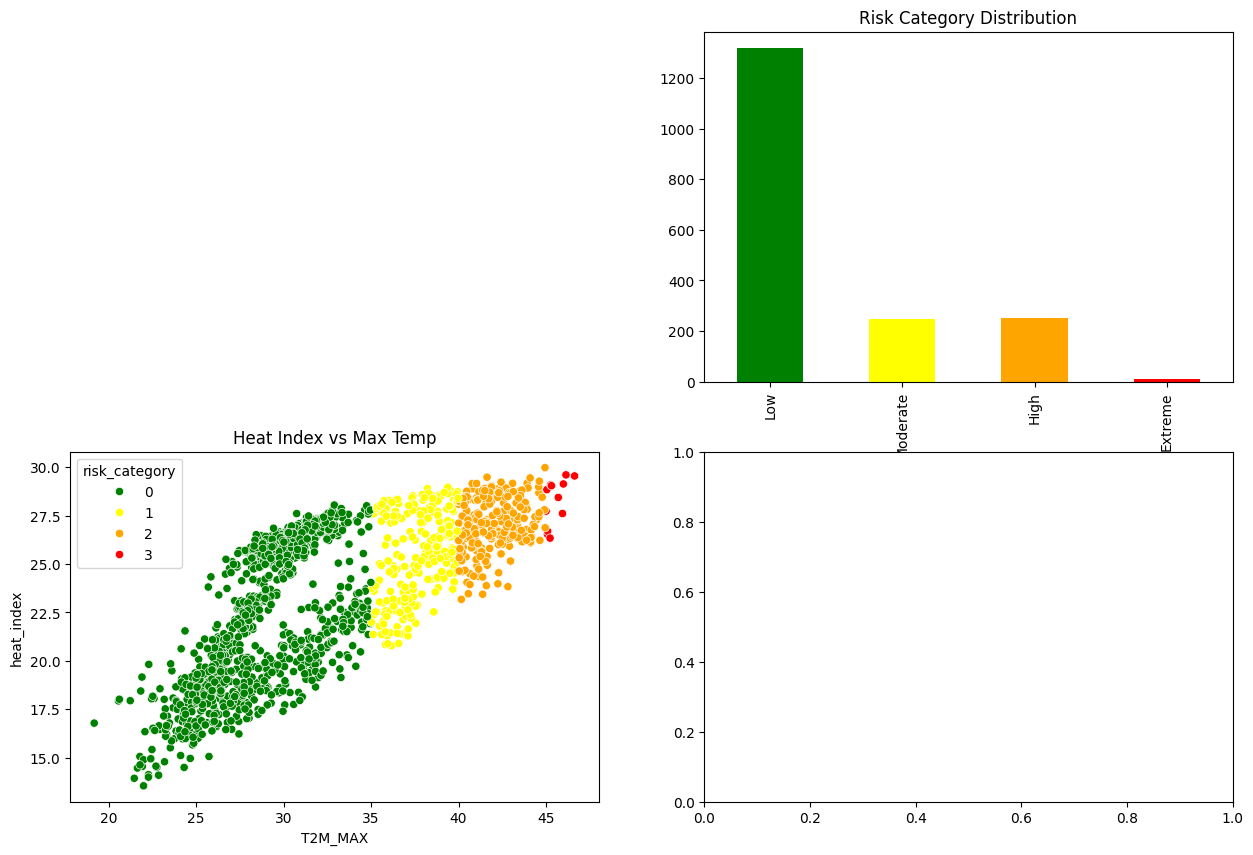

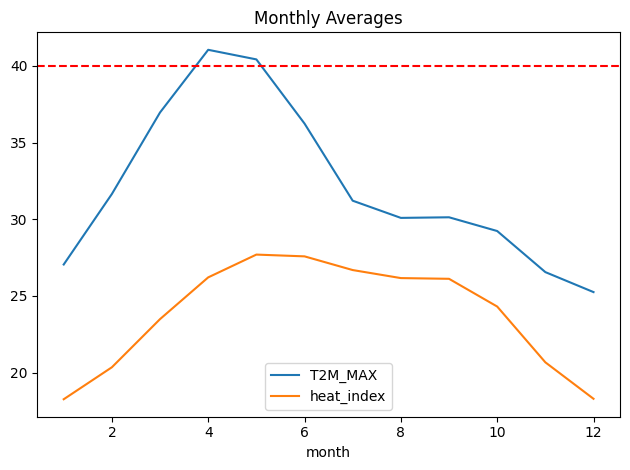

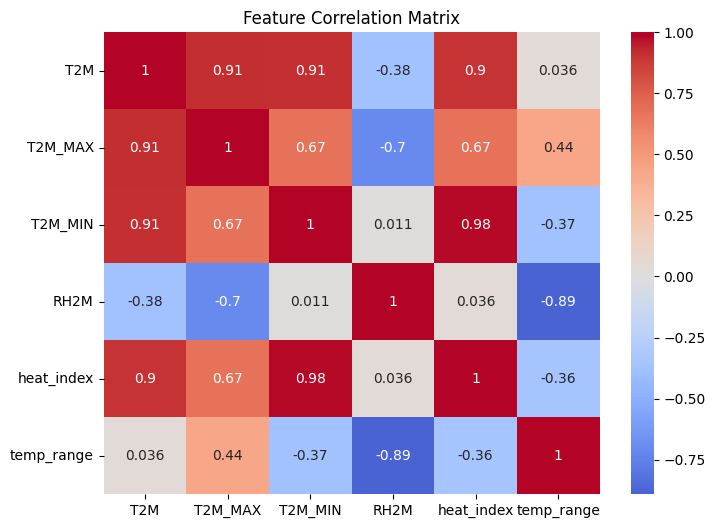

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,10))



# Risk category distribution
plt.subplot(2,2,2)
risk_counts = weather_data['risk_category'].value_counts().sort_index()
risk_counts.index = ['Low','Moderate','High','Extreme']
risk_counts.plot(kind='bar', color=['green','yellow','orange','red'])
plt.title('Risk Category Distribution')

# Heat index vs temperature
plt.subplot(2,2,3)
sns.scatterplot(x='T2M_MAX', y='heat_index', hue='risk_category',
                palette=['green','yellow','orange','red'], data=weather_data)
plt.title('Heat Index vs Max Temp')

# Monthly patterns
plt.subplot(2,2,4)
monthly_avg = weather_data.groupby('month')[['T2M_MAX','heat_index']].mean()
monthly_avg.plot(title='Monthly Averages')
plt.axhline(y=40, color='r', linestyle='--')

plt.tight_layout()
plt.show()

# Correlation analysis
plt.figure(figsize=(8,6))
corr_matrix = weather_data[['T2M','T2M_MAX','T2M_MIN','RH2M','heat_index','temp_range']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

Classification Report:
               precision    recall  f1-score   support

         Low       1.00      1.00      1.00       264
    Moderate       1.00      0.98      0.99        51
        High       1.00      1.00      1.00        49
     Extreme       1.00      1.00      1.00         2

    accuracy                           1.00       366
   macro avg       1.00      1.00      1.00       366
weighted avg       1.00      1.00      1.00       366



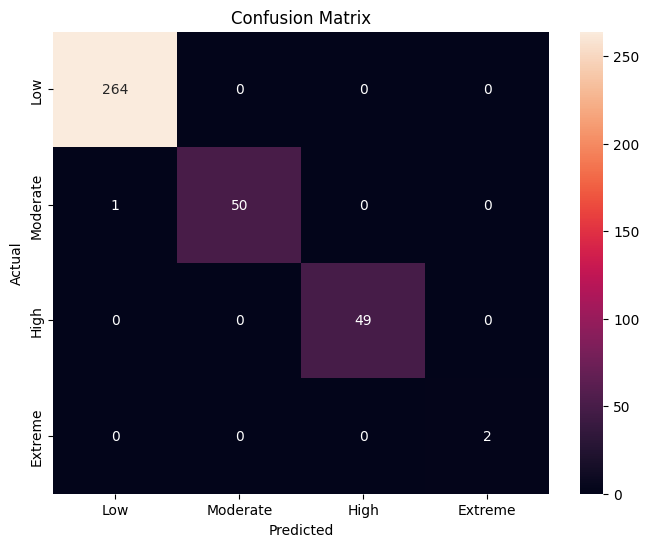

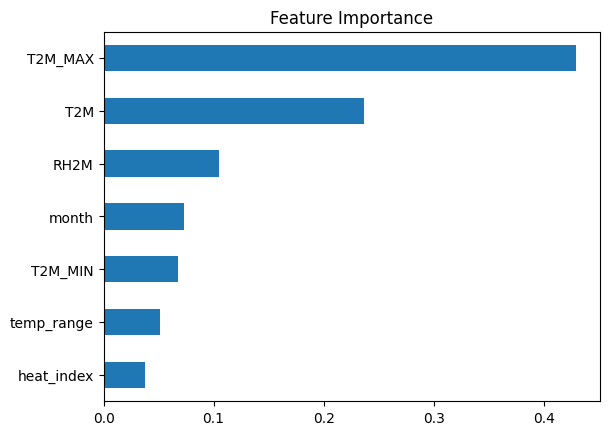

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Prepare features and target
features = ['month', 'T2M', 'T2M_MAX', 'T2M_MIN', 'RH2M', 'heat_index', 'temp_range']
X = weather_data[features]
y = weather_data['risk_category']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=150,
                           max_depth=8,
                           random_state=42,
                           class_weight='balanced')
rf.fit(X_train_scaled, y_train)

# Evaluate
y_pred = rf.predict(X_test_scaled)
print("Classification Report:\n", classification_report(y_test, y_pred,
      target_names=['Low','Moderate','High','Extreme']))

# Confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d',
            xticklabels=['Low','Moderate','High','Extreme'],
            yticklabels=['Low','Moderate','High','Extreme'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature importance
importances = pd.Series(rf.feature_importances_, index=features)
importances.sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.show()

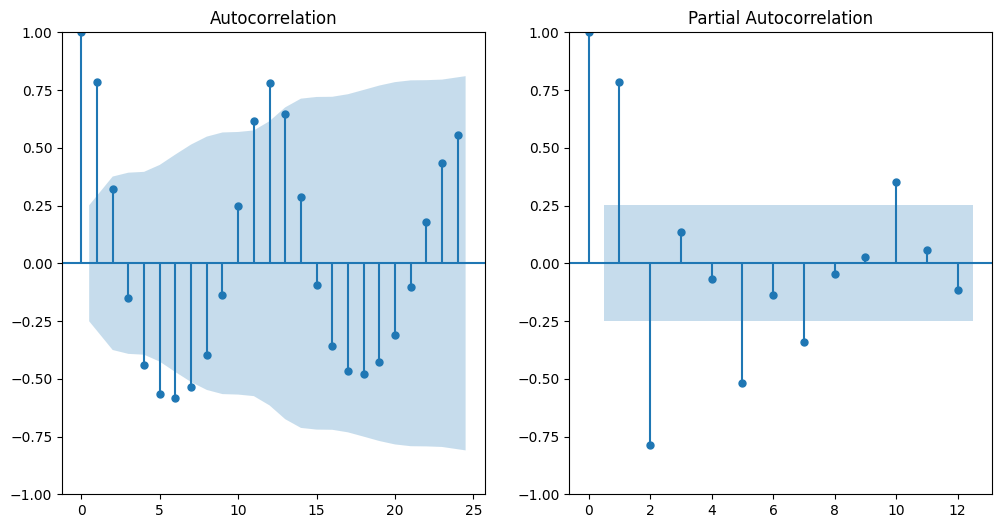

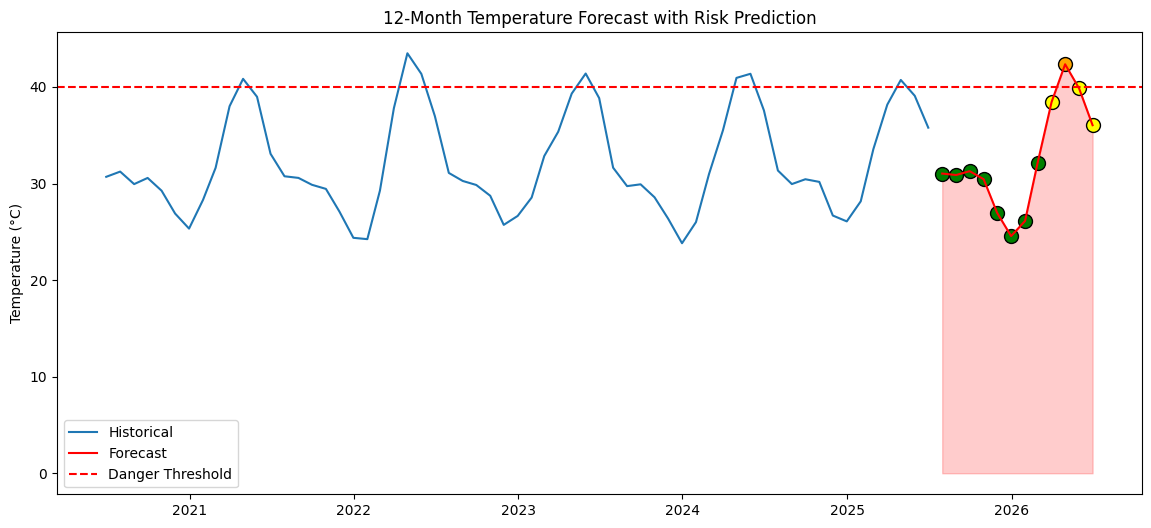

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Prepare monthly max temperature data
monthly_max = weather_data['T2M_MAX'].resample('M').mean()

# ACF/PACF plots for ARIMA parameter selection
plt.figure(figsize=(12,6))
plot_acf(monthly_max, lags=24, ax=plt.subplot(121))
plot_pacf(monthly_max, lags=12, ax=plt.subplot(122)) # Reduced lags for PACF
plt.show()

# Fit ARIMA model
model = ARIMA(monthly_max, order=(2,1,2), seasonal_order=(1,1,1,12))
model_fit = model.fit()

# Forecast next 12 months
forecast = model_fit.forecast(steps=12)
forecast_dates = pd.date_range(start=monthly_max.index[-1] + pd.Timedelta(days=1), periods=12, freq='M')

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'date': forecast_dates,
    'T2M_MAX': forecast,
    'month': forecast_dates.month
})

# Add other features by taking monthly averages
for feature in ['T2M', 'T2M_MIN', 'RH2M']:
    monthly_avg = weather_data[feature].resample('M').mean()
    forecast_df[feature] = forecast_df['month'].map(monthly_avg.groupby(monthly_avg.index.month).mean())

# Calculate derived features
forecast_df['heat_index'] = 0.5 * (forecast_df['T2M'] + 61.0 + ((forecast_df['T2M']-68.0)*1.2) + (forecast_df['RH2M']*0.094))
forecast_df['temp_range'] = forecast_df['T2M_MAX'] - forecast_df['T2M_MIN']

# Predict risk categories
X_forecast = forecast_df[features]
X_forecast_scaled = scaler.transform(X_forecast)
forecast_df['risk_category'] = rf.predict(X_forecast_scaled)

# Plot results
plt.figure(figsize=(14,6))
plt.plot(monthly_max.index, monthly_max, label='Historical')
plt.plot(forecast_df['date'], forecast_df['T2M_MAX'], label='Forecast', color='red')
plt.fill_between(forecast_df['date'],
                 forecast_df['T2M_MAX'],
                 alpha=0.2, color='red')
plt.axhline(y=40, color='r', linestyle='--', label='Danger Threshold')
plt.title('12-Month Temperature Forecast with Risk Prediction')
plt.ylabel('Temperature (°C)')
plt.legend()

# Add risk category annotations
risk_colors = {0:'green', 1:'yellow', 2:'orange', 3:'red'}
for i, row in forecast_df.iterrows():
    plt.scatter(row['date'], row['T2M_MAX'],
               color=risk_colors[row['risk_category']],
               s=100, edgecolor='black')

plt.show()

In [ ]:
# Update API request to get more parameters
params = {
    'start': start_date.strftime('%Y%m%d'),
    'end': end_date.strftime('%Y%m%d'),
    'latitude': latitude,
    'longitude': longitude,
    'community': 'AG',
    'parameters': 'T2M,T2M_MAX,T2M_MIN,RH2M,WS2M,ALLSKY_SFC_SW_DWN',
    'format': 'JSON'
}

# Get enhanced weather data
response = requests.get(url, params=params)
data = response.json()

# Create DataFrame with new parameters
enhanced_data = pd.DataFrame({
    'date': pd.to_datetime(list(data['properties']['parameter']['T2M'].keys())),
    'temperature': list(data['properties']['parameter']['T2M'].values()),
    'max_temp': list(data['properties']['parameter']['T2M_MAX'].values()),
    'min_temp': list(data['properties']['parameter']['T2M_MIN'].values()),
    'humidity': list(data['properties']['parameter']['RH2M'].values()),
    'wind_speed': list(data['properties']['parameter']['WS2M'].values()),
    'solar_radiation': list(data['properties']['parameter']['ALLSKY_SFC_SW_DWN'].values())
}).set_index('date').sort_index()

# Calculate additional features
# Using a widely accepted approximation for Heat Index in Celsius
# Source: https://www.wpc.ncep.noaa.gov/html/heatindex_thru.shtml
enhanced_data['heat_index'] = enhanced_data.apply(
    lambda row: -8.784694 + 1.611394 * row['temperature'] + 2.338549 * row['humidity'] + \
                -0.146116 * row['temperature'] * row['humidity'] + \
                -0.012308 * row['temperature']**2 + -0.016424 * row['humidity']**2 + \
                0.002211 * row['temperature']**2 * row['humidity'] + \
                0.000725 * row['temperature'] * row['humidity']**2 + \
                -0.000003 * row['temperature']**2 * row['humidity']**2,
    axis=1
)

# Handle missing values in the new columns
enhanced_data.replace(-999.0, np.nan, inplace=True)
enhanced_data.fillna(method='ffill', inplace=True) # Forward fill missing values

enhanced_data['temp_range'] = enhanced_data['max_temp'] - enhanced_data['min_temp']

print(enhanced_data.head())
print(enhanced_data.tail())

            temperature  max_temp  min_temp  humidity  wind_speed  \
date                                                                
2020-06-25        29.06     32.84     25.28     81.43        1.91   
2020-06-26        27.57     29.77     25.35     87.24        1.95   
2020-06-27        27.15     30.23     24.77     88.21        1.86   
2020-06-28        27.11     29.82     24.79     88.95        2.11   
2020-06-29        27.32     30.08     24.61     85.90        1.98   

            solar_radiation  heat_index  temp_range  
date                                                 
2020-06-25            23.76   38.354441        7.56  
2020-06-26            22.17   35.248523        4.42  
2020-06-27            20.74   34.162302        5.46  
2020-06-28            11.93   34.178043        5.03  
2020-06-29            13.54   34.227074        5.47  
            temperature  max_temp  min_temp  humidity  wind_speed  \
date                                                                


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Prepare LSTM data
def create_dataset(data, look_back=12):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

# Normalize and prepare data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(enhanced_data[['max_temp']].values)

look_back = 12
X, y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=100, batch_size=32, verbose=1)

# Make predictions
last_sequence = scaled_data[-look_back:]
future_predictions = []
for _ in range(12):  # Predict next 12 months
    pred = model.predict(last_sequence.reshape(1, look_back, 1))
    future_predictions.append(pred[0,0])
    last_sequence = np.append(last_sequence[1:], pred)

# Inverse transform predictions
lstm_forecast = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0653
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0086
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0083
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0085
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0071
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0072
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0065
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0070
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0071
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0068
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0061
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0067
Epoch 13/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0071
Epoch 14/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0056
Epoch 15/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - l

In [ ]:


def classify_risk_local(row):
    # More conservative thresholds for ranchi
    if row['max_temp'] >= 42 or (row['max_temp'] >= 38 and row['humidity'] >= 70):
        return 3  # Extreme
    elif row['max_temp'] >= 38 or (row['max_temp'] >= 35 and row['humidity'] >= 65):
        return 2  # High
    elif row['max_temp'] >= 34 or row['heat_index'] >= 30:
        return 1  # Moderate
    else:
        return 0  # Low

enhanced_data['risk_category'] = enhanced_data.apply(classify_risk_local, axis=1)

In [ ]:
from geemap import ee_to_df
import ee # Added ee import
import pandas as pd # Added pandas import

ranchi_geometry = ee.Geometry.Polygon(
    [[[85.25, 23.30], [85.25, 23.39], [85.40, 23.39], [85.40, 23.30]]]
)




def get_ndvi_data_alternative():
    modis = ee.ImageCollection('MODIS/006/MOD13A2') \
              .filterDate('2020-06-30', '2025-06-30') \
              .filterBounds(ranchi_geometry) # Assuming ranchi_geometry is defined globally or in a previous cell

    # Reduce collection to time series
    def extract_values(image):
        date = image.date().format('YYYY-MM-dd')
        ndvi = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=ranchi_geometry, # Assuming ranchi_geometry is defined globally or in a previous cell
            scale=1000
        ).get('NDVI')
        return ee.Feature(None, {'date': date, 'NDVI': ndvi})

    features = modis.map(extract_values)

    # Convert to DataFrame - Cast to FeatureCollection
    return ee_to_df(ee.FeatureCollection(features)) # Cast to FeatureCollection

ndvi_df = get_ndvi_data_alternative()
ndvi_df['NDVI'] = ndvi_df['NDVI'] / 10000  # Apply scale factor
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])

print("NDVI Data Sample:") # Added print statement
print(ndvi_df.head()) # Added print statement
print(ndvi_df.tail())

NDVI Data Sample:
       NDVI       date
0  0.409466 2020-07-11
1  0.243966 2020-07-27
2  0.282750 2020-08-12
3  0.598258 2020-08-28
4  0.556690 2020-09-13
        NDVI       date
55  0.376793 2022-12-03
56  0.352399 2022-12-19
57  0.341330 2023-01-01
58  0.311010 2023-01-17
59  0.308101 2023-02-02


In [ ]:
modis = ee.ImageCollection('MODIS/006/MOD13A2') \
    .filterDate('2020-06-30', '2025-06-30') \
    .filterBounds(ranchi_geometry)

last_image = modis.sort('system:time_start', False).first()
last_date = ee.Date(last_image.get('system:time_start')).format('YYYY-MM-dd')
print("Latest MODIS image date:", last_date.getInfo())


Latest MODIS image date: 2023-02-02


In [ ]:
# Ensure both datasets have datetime index
weather_data.index = pd.to_datetime(weather_data.index)
ndvi_df.index = pd.to_datetime(ndvi_df['date'])

# Resample both to monthly frequency (aligning MODIS 16-day with daily weather)
monthly_weather = weather_data.resample('M').mean()
monthly_ndvi = ndvi_df['NDVI'].resample('M').mean()

# Merge datasets
combined_data = pd.merge(
    monthly_weather,
    monthly_ndvi,
    left_index=True,
    right_index=True,
    how='left'
)

# Forward-fill NDVI gaps (max 2 months)
combined_data['NDVI'] = combined_data['NDVI'].fillna(method='ffill', limit=2)
print(combined_data[['T2M_MAX', 'NDVI']].tail())
print(combined_data[['T2M_MAX', 'NDVI']].head())

              T2M_MAX  NDVI
2025-02-28  33.550714   NaN
2025-03-31  38.163548   NaN
2025-04-30  40.719667   NaN
2025-05-31  39.080323   NaN
2025-06-30  35.780000   NaN
              T2M_MAX      NDVI
2020-06-30  30.691667       NaN
2020-07-31  31.232581  0.326716
2020-08-31  29.936774  0.440504
2020-09-30  30.576000  0.508388
2020-10-31  29.253548  0.502846


In [ ]:
def enhanced_risk_classification(row):
    """Improved risk assessment incorporating vegetation stress"""
    # Base risk from temperature/humidity
    if row['T2M_MAX'] >= 42:
        base_risk = 3  # Extreme
    elif row['T2M_MAX'] >= 38:
        base_risk = 2  # High
    elif row['T2M_MAX'] >= 34:
        base_risk = 1  # Moderate
    else:
        base_risk = 0  # Low

    # Adjust based on vegetation health
    if row['NDVI'] < 0.3:  # Drought conditions
        return min(base_risk + 1, 3)  # Cap at Extreme
    elif row['NDVI'] > 0.7:  # Healthy vegetation
        return max(base_risk - 1, 0)  # Floor at Low
    return base_risk

combined_data['enhanced_risk'] = combined_data.apply(enhanced_risk_classification, axis=1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from datetime import datetime, timedelta # Import timedelta
import requests # Import requests
import ee # Import ee
from geemap import ee_to_df # Import ee_to_df


# Initialize Earth Engine
ee.Initialize(project='golden-tower-460705-s9')


# Define latitude and longitude (assuming Ranchi)
latitude = 20.75
longitude = 84.25

# Date range (last 5 years)
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

# API parameters
params = {
    'start': start_date.strftime('%Y%m%d'),
    'end': end_date.strftime('%Y%m%d'),
    'latitude': latitude,
    'longitude': longitude,
    'community': 'AG',
    'parameters': 'T2M,T2M_MAX,T2M_MIN,RH2M',
    'format': 'JSON',
    'user': 'anonymous'
}

# Make the API request
url = "https://power.larc.nasa.gov/api/temporal/daily/point"
response = requests.get(url, params=params) # Assuming 'requests' is imported in a previous cell

if response.status_code == 200:
    data = response.json()
    # Convert to DataFrame - directly use the 'parameter' data
    weather_data = pd.DataFrame(data['properties']['parameter'])
    # The index of this DataFrame is already the date in 'YYYYMMDD' format string
    # Convert the index to datetime objects
    weather_data.index = pd.to_datetime(weather_data.index, format='%Y%m%d')

    # Get NDVI data
    ranchi_geometry = ee.Geometry.Polygon(
        [[[85.25, 23.30], [85.25, 23.39], [85.40, 23.39], [85.40, 23.30]]]
    )

    def get_ndvi_data_alternative():
        modis = ee.ImageCollection('MODIS/006/MOD13A2') \
                  .filterDate('2020-06-30', '2025-06-30') \
                  .filterBounds(ranchi_geometry)

        def extract_values(image):
            date = image.date().format('YYYY-MM-dd')
            ndvi = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=ranchi_geometry,
                scale=1000
            ).get('NDVI')
            return ee.Feature(None, {'date': date, 'NDVI': ndvi})

        features = modis.map(extract_values)
        return ee_to_df(ee.FeatureCollection(features))

    ndvi_df = get_ndvi_data_alternative()
    ndvi_df['NDVI'] = ndvi_df['NDVI'] / 10000  # Apply scale factor
    ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])


    # Ensure datetime index
    weather_data.index = pd.to_datetime(weather_data.index)
    ndvi_df.index = pd.to_datetime(ndvi_df['date']) # Assuming ndvi_df is defined in a previous cell

    # Resample
    monthly_weather = weather_data.resample('M').mean()
    monthly_ndvi = ndvi_df['NDVI'].resample('M').mean()

    # Merge
    combined_data = pd.merge(
        monthly_weather,
        monthly_ndvi,
        left_index=True,
        right_index=True,
        how='left'
    )

    # Forward-fill NDVI (max 2 months), then fill any remaining NaNs
    combined_data['NDVI'] = combined_data['NDVI'].fillna(method='ffill', limit=2)
    combined_data[['T2M_MAX', 'RH2M', 'NDVI']] = combined_data[['T2M_MAX', 'RH2M', 'NDVI']].interpolate().bfill().ffill()

    # Define features
    features = ['T2M_MAX', 'RH2M', 'NDVI']

    def enhanced_risk_classification(row):
        if row['T2M_MAX'] >= 42:
            base_risk = 3
        elif row['T2M_MAX'] >= 38:
            base_risk = 2
        elif row['T2M_MAX'] >= 34:
            base_risk = 1
        else:
            base_risk = 0

        if row['NDVI'] < 0.3:
            return min(base_risk + 1, 3)
        elif row['NDVI'] > 0.7:
            return max(base_risk - 1, 0)
        return base_risk

    combined_data['enhanced_risk'] = combined_data.apply(enhanced_risk_classification, axis=1)

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(combined_data[features])  # No NaNs now

    def create_sequences(data, n_steps=12):
        X, y = [], []
        for i in range(len(data) - n_steps):
            X.append(data[i:i + n_steps, :])
            y.append(data[i + n_steps, :])
        return np.array(X), np.array(y)

    look_back = 3
    X, y = create_sequences(scaled_data, look_back)

    if X.shape[0] == 0:
        print(" Not enough data to train the LSTM model. Try reducing look_back to a smaller value.")
    else:
        # Build LSTM model
        model = Sequential([
            LSTM(64, activation='relu', input_shape=(X.shape[1], X.shape[2])),
            Dense(y.shape[1], activation='linear')
        ])
        model.compile(optimizer='adam', loss='mse')

        # Train
        model.fit(X, y, epochs=100, batch_size=16, validation_split=0.2)

        # Forecast next 12 months
        last_sequence = scaled_data[-look_back:]
        future_predictions = []
        for _ in range(12):
            pred = model.predict(last_sequence.reshape(1, look_back, len(features)), verbose=0)
            future_predictions.append(pred[0])
            last_sequence = np.vstack([last_sequence[1:], pred[0]])

        lstm_forecast_scaled = np.array(future_predictions)
        lstm_forecast = scaler.inverse_transform(lstm_forecast_scaled)

        # ---- STEP 4: Forecasted Risk Classification ----

        forecast_dates = pd.date_range(start=combined_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
        lstm_forecast_df = pd.DataFrame(lstm_forecast, index=forecast_dates, columns=features)

        def simplified_forecast_risk(row):
            if row['T2M_MAX'] >= 42 or row['NDVI'] < 0.3:
                return 3
            elif row['T2M_MAX'] >= 38 or row['NDVI'] < 0.5:
                return 2
            elif row['T2M_MAX'] >= 34:
                return 1
            else:
                return 0

        lstm_forecast_df['forecasted_risk'] = lstm_forecast_df.apply(simplified_forecast_risk, axis=1)

        print("\nLSTM Forecast (next 12 months):")
        print(lstm_forecast_df)
else:
    print("Failed to fetch data:", response.status_code)
    print(response.text)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - loss: 0.5929 - val_loss: 0.4627
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5415 - val_loss: 0.4351
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5080 - val_loss: 0.4077
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.4793 - val_loss: 0.3808
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.4249 - val_loss: 0.3537
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.4033 - val_loss: 0.3267
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.3610 - val_loss: 0.2990
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3353 - val_loss: 0.2708
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2813 - val_loss: 0.2426
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2467 - val_loss: 0.2140
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2111 - val_loss: 0.1856
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1772 - val_l

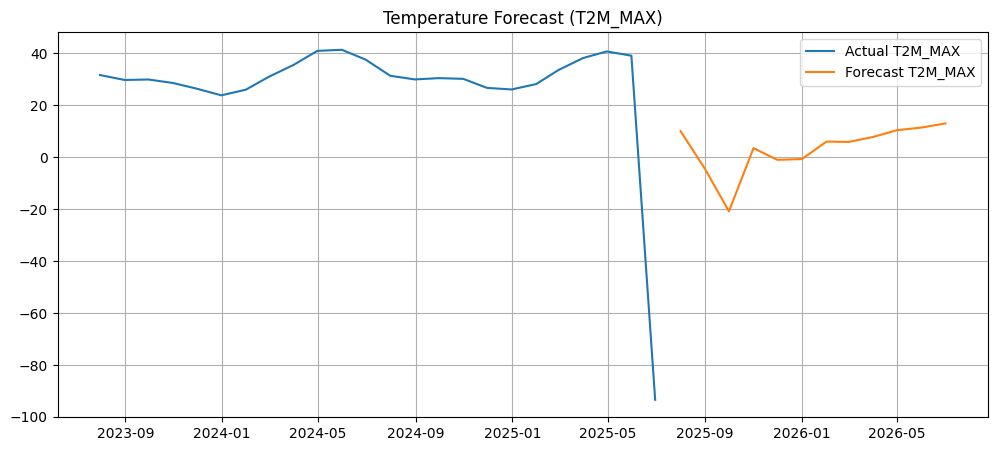

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(combined_data['T2M_MAX'][-24:], label='Actual T2M_MAX')
plt.plot(lstm_forecast_df['T2M_MAX'], label='Forecast T2M_MAX')
plt.title("Temperature Forecast (T2M_MAX)")
plt.legend()
plt.grid()
plt.show()


random forest on same parameters
